# Automatic TICI

## Import modules

In [36]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from scipy.io import loadmat
from sklearn.model_selection import KFold
import skimage.filters as filters

## Select Feature Image

In [66]:
def gray2binary(image_set):
    thresholds = list(map(filters.threshold_li, image_set))
    # When an image's frequency is too low, filters.threshold_li may 
    # cause a divide-by-zero RuntimeWarning, and the corresponding
    # threshold will be 0. So we need to remove zeros in thresholds.
    new_image_set = []
    for i in range(len(image_set)):
        if thresholds[i] > 0:
            new_image_set.append(image_set[i])
    
    thresholds = list(filter(lambda th: th > 0, thresholds))
#     print(thresholds)
    
    result = []
    for i in range(len(thresholds)):
        result.append(new_image_set[i] > thresholds[i])
    return new_image_set, result

In [39]:
def summarize_middle_artery(image_set):
    # Assume all the images in an image set have the same dimensions.
    image_count, image_height, image_width = np.shape(image_set)
    result = []
    for image in image_set:
        # Only consider the middle 1/4 of the upper 1/4 image.
        middle_section = image[0:int(image_height/4), int(image_width*3/8):int(image_width*5/8)]
        # plt.figure()
        # plt.imshow(middle_section, cmap='gray')
        
        summary = np.array(list(map(all, middle_section)))
        # print(np.count_nonzero(summary))

        # summary = np.tile(summary[:, np.newaxis], 200)
        result.append(summary)
    return np.array(result)

In [62]:
def choose_image(image_set):
    new_image_set, binary_image_set = gray2binary(image_set)
    middle_artery_summary_image_set = summarize_middle_artery(binary_image_set)
    image_count, image_height = np.shape(middle_artery_summary_image_set)
    
    flagOn = False
    previous_nonzeroCount = -1
#     print(image_height, image_height/2)
    
    for i in range(image_count):
        nonzeroCount = np.count_nonzero(middle_artery_summary_image_set[i])
        
#         print (flagOn, nonzeroCount, nonzeroCount - previous_nonzeroCount)
        
        if flagOn and nonzeroCount > 0 and nonzeroCount < image_height/2:
            return True, new_image_set[i]
        elif previous_nonzeroCount >= 0 and nonzeroCount > image_height/2:
            flagOn = True
        previous_nonzeroCount = nonzeroCount
    return False, None

## Load data & extract images and TICI scores

In [41]:
# Get the path of the data directory.
data_dir = os.path.join(os.getcwd(), 'data')
# Get a list of full paths of all mat files in the data directory.
for root, _dirs, files in os.walk(data_dir):
    files = list(filter(lambda fname: fname.lower().endswith('.mat'), sorted(files)))
nfiles = len(files)
print('{} files found in the data directory \'{}\'.'.format(nfiles, data_dir))

201 files found in the data directory '/Users/ceciliawang/Desktop/UCLA/Senior Year/Spring 2019/CS 168/CS168-Automatic-TICI/data'.


In [60]:
# Given the data_dir and a file name, extract an image from
# the set of images and the TICI score.
# By default, nothing is printed.
# If verbose=1, print the keys of the mat file content (which is a dictionary).
# If verbose=2, print the 3 TICI scores for debugging purpose.
def extract_data_file(data_dir, fname, verbose=False):
    content = loadmat(os.path.join(data_dir, fname))
    
    if verbose == 1:
        print('{}\tkeys={}'.format(fname, sorted(content.keys())))
    if verbose == 2:
        print('{}\t\tTICI_Dr1={}\tTICI_Dr2={}\tTICI_report={}'.format(fname, content['TICI_Dr1'], content['TICI_Dr2'], content['TICI_report']))

    raw_image_set, TICI = content['X'], content['TICI_report']
    # Originally, raw_image_set[:, :, k] is the kth image.
    # Reorder the dimensions such that raw_image_set[k, :, :] is the kth image.
    image_set = np.transpose(raw_image_set, (2, 0, 1))
    # Only one image from each image set is selected to be fed into the model.
    # For simplicity, the image in the middle of each image set is selected just for now.
    count, _, __ = np.shape(image_set)
    imgNotNone, image = choose_image(image_set)
    return imgNotNone, image, TICI

In [63]:
# From the first mat file, learn the structure and the image set dimensions.
# Assume that all mat files have the same structure and that all the images 
# in each image set have the same dimensions, though each image sets may
# contain various number of images.
_, sample_image, sample_TICI = extract_data_file(data_dir, files[0], verbose=1)
image_shape = sample_image.shape
print(image_shape)

fractals_1.mat	keys=['TICI_Dr1', 'TICI_Dr2', 'TICI_report', 'X', '__globals__', '__header__', '__version__']
[0.008492869172541283, 0.008483918574166211, 0.008465017673559786, 0.00848054197728808, 0.008482379499903447, 0.008466404054233616, 0.008404657722212935, 0.008220486859550503, 0.006517470518339202, 0.006395157874710995, 0.006622612768717272, 0.006745116942743873, 0.006869359357606706, 0.007082249130746357, 0.007386930711639393, 0.007646731422202598, 0.007749642451115544, 0.007750620444229103, 0.007840704481734958, 0.007977589821534913]
(1024, 1024)


fractals_1.mat		TICI_Dr1=['2b']	TICI_Dr2=['2b']	TICI_report=['2a']
[0.008492869172541283, 0.008483918574166211, 0.008465017673559786, 0.00848054197728808, 0.008482379499903447, 0.008466404054233616, 0.008404657722212935, 0.008220486859550503, 0.006517470518339202, 0.006395157874710995, 0.006622612768717272, 0.006745116942743873, 0.006869359357606706, 0.007082249130746357, 0.007386930711639393, 0.007646731422202598, 0.007749642451115544, 0.007750620444229103, 0.007840704481734958, 0.007977589821534913]
<class 'numpy.ndarray'>
fractals_10.mat		TICI_Dr1=[[nan]]	TICI_Dr2=[[nan]]	TICI_report=['2a']


/usr/local/lib/python3.7/site-packages/skimage/filters/thresholding.py:596: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


[0.00970525757971043, 0.009584088817110639, 0.009599692165438437, 0.00694644409258623, 0.00650689278336047, 0.007041529425380954, 0.007197248492152609, 0.007494164792970992, 0.00830344843131434, 0.008393320620641406, 0.008804667786804722, 0.009112270053441944, 0.009167236229779378, 0.009098100783116526, 0.009023428389546605, 0.008486336154249203, 0.008606735331672315]
<class 'numpy.ndarray'>
fractals_100.mat		TICI_Dr1=[[nan]]	TICI_Dr2=[[nan]]	TICI_report=[[3]]
[0.010126081442930224, 0.007022049166846112, 0.006991402042251066, 0.006975061065555508, 0.006821661943895928, 0.006688614635243549, 0.0067148331907729815, 0.006347007829823946, 0.006609820702521573, 0.006749276708993154, 0.006870004494457099, 0.006947153208796008, 0.007223957946619421, 0.0070852160751965505, 0.007039311187074188, 0.007209045318943989]
<class 'numpy.ndarray'>
fractals_101.mat		TICI_Dr1=[[nan]]	TICI_Dr2=[[nan]]	TICI_report=[[0]]
[0.009820904428089321, 0.009816878607916617, 0.009820358272920673, 0.00985600295097164

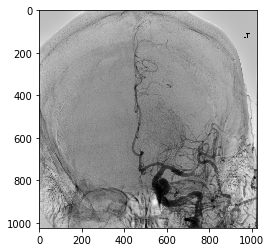

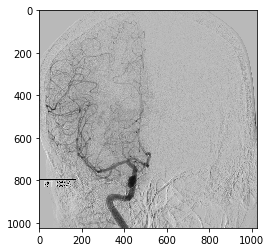

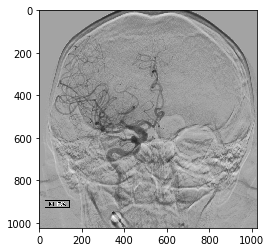

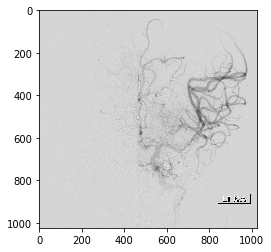

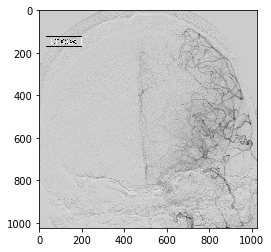

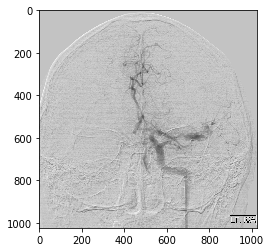

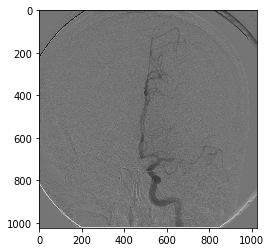

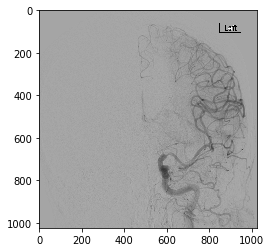

In [64]:
# For debugging purpose, print the 3 TICI scores for the first 10 mat files.
for n in range(10):
    imgNotNone,  image , _ = extract_data_file(data_dir, files[n], verbose=2)
    print(type(image))
    if imgNotNone:
        plt.figure()
        plt.imshow(image, cmap='gray')

In [67]:
# Initialize a list for images and a numpy arrays for 
# corresponding TICI scores. Assume all images have 
# the same dimensions. The TICI score in each 
images = []
TICI_strings = []

# Extract image and TICI information for all mat files.
for n in range(nfiles):
    # Print the extracting progress.
    if n % 10 == 0:
        print('{} / {} done'.format(n, nfiles))
    imgNotNone, image, TICI = extract_data_file(data_dir, files[n])
    if imgNotNone:
        images.append(image)
        # The TICI scores in the mat files are in the form of 
        # nested np.ndarray's of either strings, numbers, of nan.
        # e.g., ['2a'], [[3]], [[nan]]. With assumption of 
        # this structure, simplify TICI before append it to TICIs.
        while isinstance(TICI, np.ndarray):
            TICI = TICI[0] if len(TICI) > 0 else ''
        TICI_strings.append(str(TICI))

usedfiles, _, _ = np.shape(images)
print(np.shape(images))
print(TICI_strings)

0 / 201 done


/usr/local/lib/python3.7/site-packages/skimage/filters/thresholding.py:596: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


10 / 201 done
20 / 201 done
30 / 201 done


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


40 / 201 done
50 / 201 done
60 / 201 done
70 / 201 done
80 / 201 done
90 / 201 done
100 / 201 done
110 / 201 done
120 / 201 done
130 / 201 done
140 / 201 done
150 / 201 done
160 / 201 done
170 / 201 done
180 / 201 done
190 / 201 done
200 / 201 done
(162, 1024, 1024)
['2a', '2a', '3', 'nan', '2b', '0', '0', '2a', '2a', '2a', '2b', '0', '2b', '2b', '0', 'nan', '3', 'nan', '2b', '1', '2b', '2a', '0', '2b', '2b', 'nan', '0', '2a', '2a', '3', '2b', '2b', '2a', 'nan', '2b', 'nan', '0', '2a', '3', '2b', '2b', '2b', '2a', '2b', '3', '2a', '2a', '2b', '2a', '2b', '2b', '2b', '2a', '1', '2a', '2a', '2a', '3', '0', '2a', '2a', '2b', '2b', '2a', '2a', '2b', '1', '2a', '2a', '2b', '2b', '2a', '3', '2b', '0', '0', '0 (bilateral MCA)', '0', '0', '2b', '3', '3', '2b', '0', '2a', '2a', '0', '2b', '2a', '2b', '2b', '2b', '2b', '2a', '2b', '2a?', '2b', '0', '2a', 'nan', '2b', '2b', '2b', 'nan', '2a', '2a', '2b', '1', '2b', '1', '2b', '2a', 'nan', '2b', '2a', '2b', '2a', '2b', '2b', 'nan', '2b', '0', '2b'

## Reformat TICI scores

In [68]:
# The number of different TICI scores.
# Including 0, 1, 2a, 2b, 3, nan.
num_TICI_classes = 6

# Convert a TICI string to a number
def map_TICI_str_to_num(TICI):
    relation = {
        '0': 0,
        '1': 1,
        '2a': 2,
        '2b': 3,
        '3': 4,
        'nan': 5,
        '0 (bilateral MCA)': 0,
        '2a?': 2
    }
    return relation[TICI]

# Convert a numerical encoded TICI to a string
def map_TICI_num_to_str(label):
    relation = ['0', '1', '2a', '2b', '3', 'nan']
    return relation[label]

# Convert TICI scores in the form of strings to numeric labels before fed to the model.
TICI_nums = list(map(map_TICI_str_to_num, TICI_strings))
print(TICI_nums)

# Convert the array of integer labels (0 ~ num_TICI_classes-1) to an array of 
# one-hot (aka one-of-K) encoded labels, for better accuracy.
TICI_one_hot = tf.keras.utils.to_categorical(TICI_nums, num_TICI_classes)
print(TICI_one_hot)

[2, 2, 4, 5, 3, 0, 0, 2, 2, 2, 3, 0, 3, 3, 0, 5, 4, 5, 3, 1, 3, 2, 0, 3, 3, 5, 0, 2, 2, 4, 3, 3, 2, 5, 3, 5, 0, 2, 4, 3, 3, 3, 2, 3, 4, 2, 2, 3, 2, 3, 3, 3, 2, 1, 2, 2, 2, 4, 0, 2, 2, 3, 3, 2, 2, 3, 1, 2, 2, 3, 3, 2, 4, 3, 0, 0, 0, 0, 0, 3, 4, 4, 3, 0, 2, 2, 0, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 0, 2, 5, 3, 3, 3, 5, 2, 2, 3, 1, 3, 1, 3, 2, 5, 3, 2, 3, 2, 3, 3, 5, 3, 0, 3, 0, 3, 5, 4, 3, 2, 2, 2, 3, 4, 5, 3, 3, 3, 3, 4, 5, 4, 5, 3, 3, 4, 2, 2, 3, 3, 2, 2, 3, 2, 2, 3, 5, 5, 5, 3, 3, 3, 2]
[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0

In [69]:
# Build the model with tensorflow.keras.
# The general idea is to reduce the size by maxpooling and 
# extract more features with convolutions of an increasing 
# number of filters.
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu', 
                        input_shape=(image_shape[0], image_shape[1], 1)),  # learn why the 1 is required...
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((4, 4), (4, 4), padding='same'),
    tf.keras.layers.Flatten(),
    # keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_TICI_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 1024, 32)    832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dropout (Dropout)            (None, 262144)            0

In [70]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

In [72]:
# Add one dimension to the images input for channels.
images_as_model_input = np.array(images).reshape(usedfiles, image_shape[0], image_shape[1], 1)
print(images_as_model_input.shape)    

(162, 1024, 1024, 1)


In [76]:
# K-fold cross validation
kf = KFold(n_splits=4) 
# Image augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

BATCH_SIZE = 10
EPOCHS = 3

for train_index, test_index in kf.split(images_as_model_input):
    x_train, x_val = images_as_model_input[train_index], images_as_model_input[test_index]
    y_train, y_val = TICI_one_hot[train_index], TICI_one_hot[test_index]
    datagen.fit(x_train)
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        steps_per_epoch=len(x_train) / BATCH_SIZE, 
                        epochs=EPOCHS, 
                        verbose=1,
                        validation_data=datagen.flow(x_val, y_val, batch_size=BATCH_SIZE))

Epoch 1/3
13/12 [================================] - 84s 6s/step - loss: 63.7465 - accuracy: 0.2645 - val_loss: 8.2099 - val_accuracy: 0.0732
Epoch 2/3
13/12 [================================] - 70s 5s/step - loss: 31.9003 - accuracy: 0.2479 - val_loss: 5.2838 - val_accuracy: 0.2683
Epoch 3/3
13/12 [================================] - 67s 5s/step - loss: 20.8214 - accuracy: 0.3967 - val_loss: 7.7890 - val_accuracy: 0.3171
Epoch 1/3
13/12 [================================] - 72s 6s/step - loss: 17.5551 - accuracy: 0.2231 - val_loss: 9.9741 - val_accuracy: 0.1220
Epoch 2/3
13/12 [================================] - 71s 5s/step - loss: 23.8185 - accuracy: 0.3471 - val_loss: 6.2832 - val_accuracy: 0.2195
Epoch 3/3
13/12 [================================] - 71s 5s/step - loss: 23.7469 - accuracy: 0.2645 - val_loss: 5.3646 - val_accuracy: 0.2927
Epoch 1/3
13/12 [===============================] - 91s 7s/step - loss: 44.5119 - accuracy: 0.2787 - val_loss: 4.1133 - val_accuracy: 0.2000
Epoch 2